In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
import nibabel as nib
from os.path import join
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import sys
sys.path.append('../general_functions/')
from plotting_brains_surfplot import map_values_to_atlas,  make_translucent_map, Plot
from nilearn import datasets, plotting


/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [3]:
from surfplot.surf import plot_surf
#from surfplot import Plot -- importing modified Class
from brainspace.datasets import load_parcellation
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
atlas_surf = load_parcellation('schaefer', 100, join = True)

#DEFINING THE COLOR MAPS
from matplotlib.colors import LinearSegmentedColormap


basic_cols=['k', 'k', 'k']
black_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

# Combine them

In [4]:
def try_int(val):
    try:
        return int(val) - 1
    except ValueError:
        return val



In [16]:

def fdr_correction_with_exclusions(df, p_value_col):
    """Apply FDR correction to p-values, handling NaNs or exclusions."""
    p_values = df[p_value_col].values
    mask = ~np.isnan(p_values)  # Identify non-NaN values
    
    if mask.sum() == 0:  # If all are NaN
        return np.ones(len(p_values)) * np.nan
    
    # Apply correction only to non-NaN values
    reject, q_values_valid = fdrcorrection(p_values[mask])
    
    # Initialize all q-values as NaN
    q_values = np.ones(len(p_values)) * np.nan
    
    # Replace only the non-NaN positions with calculated q-values
    q_values[mask] = q_values_valid
    
    return q_values

def load_and_preprocess_data(event_num='_event_3'):
    """Load all CSV files and apply FDR correction once."""
    dfs = {
    'L2_more_than_0': pd.read_csv(f'../../data/model_outputs_steve{event_num}/Steve_L2_event1_t_test_results{event_num}.csv'),
    'L2_more_than_L1': pd.read_csv(f'../../data/model_outputs_steve{event_num}/Steve_L2_event1_vs_L1_t_test_results{event_num}.csv'),       
    'L1_slope_pos': pd.read_csv(f"../../data/model_outputs_steve{event_num}/across_node_estimate_p_r_event_steve_L1{event_num}.csv"),
    'L2_slope_pos': pd.read_csv(f"../../data/model_outputs_steve{event_num}/across_node_estimate_p_r_event_steve_L2{event_num}.csv"),
    'L1_slope_more_L2': pd.read_csv(f"../../data/model_outputs_steve{event_num}/across_node_estimate_p_r_event_listen_steve_interaction{event_num}.csv"),
    'L1_lucy_slope': pd.read_csv(f"../../data/model_outputs_steve{event_num}/across_node_estimate_p_r_event_lucy_L1{event_num}.csv"),
    'L2_lucy_slope': pd.read_csv(f"../../data/model_outputs_steve{event_num}/across_node_estimate_p_r_event_lucy_L2{event_num}.csv")
}
    
    # Apply FDR correction 
    dfs['L2_more_than_0']['q_value'] = fdr_correction_with_exclusions(dfs['L2_more_than_0'], 'p_value')
    dfs['L2_more_than_L1']['q_value'] = fdr_correction_with_exclusions(dfs['L2_more_than_L1'], 'p_value')
    dfs['L1_slope_pos']['q_value'] = fdr_correction_with_exclusions(dfs['L1_slope_pos'], 'event_p_value')
    dfs['L2_slope_pos']['q_value'] = fdr_correction_with_exclusions(dfs['L2_slope_pos'], 'event_p_value')
    dfs['L1_slope_more_L2']['q_value'] = fdr_correction_with_exclusions(
        dfs['L1_slope_more_L2'], 'event_listenL1_greater_p_value'
    )
    dfs['L1_lucy_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L1_lucy_slope'], 'event_p_value')
    dfs['L2_lucy_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L2_lucy_slope'], 'event_p_value')
    
    return dfs

def create_merged_dataframe(dfs):
    """Create a clean merged dataframe with consistent column naming."""
    # Prepare each dataframe with clear column names before merging
    L2_more_than_0 = dfs['L2_more_than_0'][['node', 't_statistic', 'p_value', 'q_value']].rename(
        columns={
            't_statistic': 'L2_more_than_0_t',
            'p_value': 'L2_more_than_0_p',
            'q_value': 'L2_more_than_0_q'
        }
    )
    L2_more_than_L1 = dfs['L2_more_than_L1'][['node', 't_statistic', 'p_value', 'q_value']].rename(
        columns={
            't_statistic': 'L2_more_than_L1_t',
            'p_value': 'L2_more_than_L1_p',
            'q_value': 'L2_more_than_L1_q'
        }
    )
    
    L1_slope_pos = dfs['L1_slope_pos'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L1_slope_pos_estimate',
            'event_p_value': 'L1_slope_pos_p',
            'q_value': 'L1_slope_pos_q'
        }
    )
    L2_slope_pos = dfs['L2_slope_pos'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L2_slope_pos_estimate',
            'event_p_value': 'L2_slope_pos_p',
            'q_value': 'L2_slope_pos_q'
        }
    )
    
    L1_slope_more_L2 = dfs['L1_slope_more_L2'][
        ['node', 'event_listenL1_greater_estimate', 'event_listenL1_greater_p_value', 'q_value']
    ].rename(
        columns={
            'event_listenL1_greater_estimate': 'L1_slope_more_L2_estimate',
            'event_listenL1_greater_p_value': 'L1_slope_more_L2_p',
            'q_value': 'L1_slope_more_L2_q'
        }
    )
    
    L1_lucy_slope = dfs['L1_lucy_slope'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L1_lucy_slope_estimate',
            'event_p_value': 'L1_lucy_slope_p',
            'q_value': 'L1_lucy_slope_q'
        }
    )
    
    L2_lucy_slope = dfs['L2_lucy_slope'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L2_lucy_slope_estimate',
            'event_p_value': 'L2_lucy_slope_p',
            'q_value': 'L2_lucy_slope_q'
        }
    )
    
    merged_df = L2_more_than_0.merge(
        L1_slope_pos, on='node'
    ).merge(
        L2_more_than_L1, on='node'
    ).merge(
        L2_slope_pos, on='node'
    ).merge(
        L1_slope_more_L2, on='node'
    ).merge(
        L1_lucy_slope, on='node'
    ).merge(
        L2_lucy_slope, on='node'
    )
    
    return merged_df

def get_contour_levels(merged_df):
    """Get different contour levels based on varying criteria strictness."""
    # Define filter functions for different contour levels
    def basic_filter(df):
        """Basic filter using p-values."""
        return df[
            (df['L2_more_than_0_t'] > 0) &
            (df['L1_slope_pos_estimate'] > 0) &
            (df['L1_slope_pos_estimate'] > 0) &
            ((df['L2_slope_pos_estimate'] > 0) | (df['L2_slope_pos_p'] >= 0.05)) &
            (df['L1_slope_more_L2_estimate'] > 0) &
            ((df['L1_lucy_slope_estimate'] < 0) | (df['L1_lucy_slope_p'] >= 0.05)) &
            ((df['L2_lucy_slope_estimate'] < 0) | (df['L2_lucy_slope_p'] >= 0.05))
        ]
    
    def basic_p_value_filter(df):
        """Basic filter using p-values."""
        return df[
            (df['L2_more_than_0_t'] > 0) & (df['L2_more_than_0_p'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_p'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_p'] < 0.05) &
#             (df['L2_slope_pos_estimate'] > 0) & (df['L2_slope_pos_p'] < 0.05) &
            ((df['L2_slope_pos_estimate'] > 0) | (df['L2_slope_pos_p'] >= 0.05)) &
            (df['L1_slope_more_L2_estimate'] > 0) & (df['L1_slope_more_L2_p'] < 0.05) &
            ((df['L1_lucy_slope_estimate'] < 0) | (df['L1_lucy_slope_p'] >= 0.05)) &
            ((df['L2_lucy_slope_estimate'] < 0) | (df['L2_lucy_slope_p'] >= 0.05))
        ]
    
    def strict_q_value_filter(df):
        """Strict filter using q-values and requiring negative estimates."""
        return df[
            (df['L2_more_than_0_t'] > 0) & (df['L2_more_than_0_q'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_q'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_q'] < 0.05) &
            ((df['L2_slope_pos_estimate'] > 0) | (df['L2_slope_pos_p'] >= 0.05)) &
            (df['L1_slope_more_L2_estimate'] > 0) & (df['L1_slope_more_L2_q'] < 0.05) &
            (df['L1_lucy_slope_estimate'] < 0) &
            (df['L2_lucy_slope_estimate'] < 0)
        ]
    
    def loose_q_filter(df):
        """Mixed filter with some q-values and some p-values."""
        return df[
            (df['L2_more_than_0_t'] > 0) & (df['L2_more_than_0_p'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_p'] < 0.05) &
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_p'] < 0.05) &
            ((df['L2_slope_pos_estimate'] > 0) | (df['L2_slope_pos_p'] >= 0.05)) &
            (df['L1_slope_more_L2_estimate'] > 0) & (df['L1_slope_more_L2_q'] < 0.05) &
            ((df['L1_lucy_slope_estimate'] < 0) | (df['L1_lucy_slope_p'] >= 0.05)) &
            ((df['L2_lucy_slope_estimate'] < 0) | (df['L2_lucy_slope_p'] >= 0.05))
        ]
    
    contours = {
        'basic_direction': basic_filter(merged_df),
        'basic_p': basic_p_value_filter(merged_df),
        'strict': strict_q_value_filter(merged_df),
        'imp_q': loose_q_filter(merged_df)
    }
    return contours

def main(event_num = '_event_3'):
    dfs = load_and_preprocess_data(event_num=event_num) 
    
    merged_df = create_merged_dataframe(dfs)
    
    contours = get_contour_levels(merged_df)
    
    for name, contour_df in contours.items():
        print(f"Contour level '{name}' has {len(contour_df)} nodes")
    
    return merged_df, contours


event_num = '_event_4' #modify here if want to test the other sizes of the template -- 2 or 4 (for the supplement)
if __name__ == "__main__":
    merged_df, contours = main(event_num)
    
    
selected_nodes = contours['basic_p']
selected_nodes_to_save = contours['basic_direction']
selected_nodes_contours = contours['imp_q']

all_sub = pd.read_csv(f"../../data/model_outputs_Steve{event_num}/across_node_estimate_p_r_event_listen_steve_interaction{event_num}.csv")

column = 'event_listenL1_greater' 
all_sub['estimate'] = all_sub[f'{column}_estimate']
all_sub['p'] = all_sub[f'{column}_p_value']


Contour level 'basic_direction' has 190 nodes
Contour level 'basic_p' has 56 nodes
Contour level 'strict' has 8 nodes
Contour level 'imp_q' has 56 nodes


102
_event_4


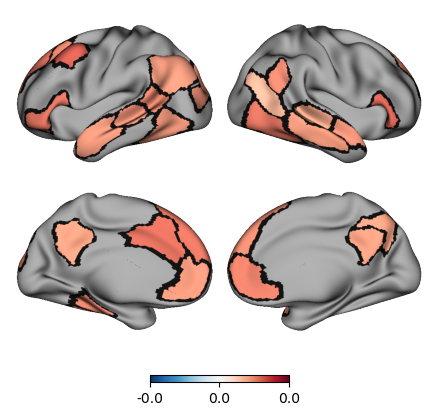

In [17]:
### want to basically plot the effect in this analysis only in the regions that show effects in the above! 
bad_ROIs = [30, 31, 32, 78, 79]
selected_nodes_list = [try_int(val) for val in selected_nodes_to_save['node']] 

vals = []
for node in range(0,102):
    if node==100 and 'hippocampus_L' in selected_nodes_list:
        vals.append(all_sub['estimate'][100])
    elif node==101 and 'hippocampus_R' in selected_nodes_list:
        vals.append(all_sub['estimate'][101])
    elif node in selected_nodes_list and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)
        
#for saving not plotting purposes, going to tack on the hippocampus to this, adding in only the left since the right is not sig! 
vals_to_save = vals #+ [list(all_sub[all_sub['node']=='hippocampus_L'][f'{column}_estimate'])[0], list(all_sub[all_sub['node']=='hippocampus_R'][f'{column}_estimate'])[0]] 
print(len(vals_to_save))
if event_num=='_event_3':
    np.save('character_analyses_distribution_filtering_regions_for_clustering_steve.npy', vals_to_save)


#Then want to just plot the ones that have the actual effects in them
selected_nodes_list = [try_int(val) for val in selected_nodes['node']]
vals = []
for node in range(100):
    if node in selected_nodes_list and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)
new_array = map_values_to_atlas(atlas_surf, np.array(vals))

translucent_map = make_translucent_map(new_array, np.nanmax(np.abs(new_array))*.20, new_array)
translucent_map 

p = Plot(lh, rh, views=['lateral', 'medial'])

p.add_layer(translucent_map , cbar=True, cmap='RdBu_r', color_range=(-.005, .005), zero_transparent=False)


selected_nodes_contours_plot = [try_int(val) for val in selected_nodes_contours['node']]


for region in selected_nodes_contours_plot:
    if region in selected_nodes_list and region not in bad_ROIs:
        p_plot = [0] * 100
        p_plot[region] = 1  # Mark the current region
        p_array = map_values_to_atlas(atlas_surf, p_plot)

        # Add this region as a separate layer
        p.add_layer(p_array, cmap=black_cmap, as_outline=True, cbar=False, outline_thickness=2)
        
fig = p.build()  

print(event_num)
fig.savefig(f'../../plots/03._character_representation_analyses/01._character_rep_cortical_fig_steve_{event_num}.png', dpi=300,transparent=True)
fig.savefig(f'../../plots/03._character_representation_analyses/01._character_rep_cortical_fig_steve_{event_num}.svg', dpi=300,transparent=True)



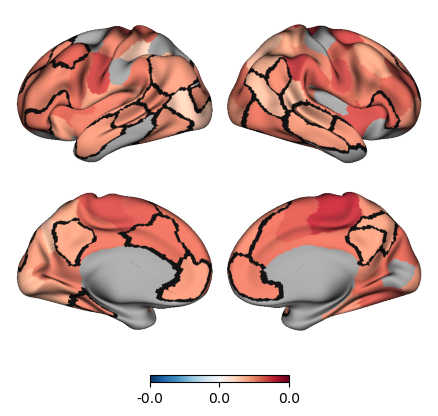

In [18]:
### want to basically plot the effect in this analysis only in the regions that show effects in the above! 
bad_ROIs = [30, 31, 32, 78, 79]

selected_nodes_list = [try_int(val) for val in selected_nodes_to_save['node']]
vals = []
for node in range(100):
    if node in selected_nodes_list and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)
new_array = map_values_to_atlas(atlas_surf, np.array(vals))

translucent_map = make_translucent_map(new_array, np.nanmax(np.abs(new_array))*.20, new_array)
translucent_map 

p = Plot(lh, rh, views=['lateral', 'medial'])

p.add_layer(translucent_map , cbar=True, cmap='RdBu_r', color_range=(-.005, .005), zero_transparent=False)


selected_nodes_contours_plot = [try_int(val) for val in selected_nodes_contours['node']]


for region in selected_nodes_contours_plot:
    if region in selected_nodes_list and region not in bad_ROIs:
        p_plot = [0] * 100
        p_plot[region] = 1  # Mark the current region
        p_array = map_values_to_atlas(atlas_surf, p_plot)

        # Add this region as a separate layer
        p.add_layer(p_array, cmap=black_cmap, as_outline=True, cbar=False, outline_thickness=2)
        

fig = p.build()  

fig.savefig(f'../../plots/03._character_representation_analyses/01._character_rep_cortical_fig_steve_{event_num}_all.png', dpi=300,transparent=True)
fig.savefig(f'../../plots/03._character_representation_analyses/01._character_rep_cortical_fig_steve_{event_num}_all.svg', dpi=300,transparent=True)



/Users/f004p59/miniconda3/envs/brainiak_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:852: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, data, affine)
/Users/f004p59/miniconda3/envs/brainiak_py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument t

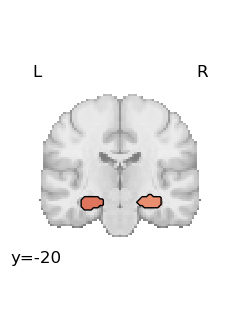

In [19]:

# Since they are in the same one plot them together!! 
atlas_name = 'sub-maxprob-thr0-2mm'
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name)

atlas = harvard_oxford.maps

hippocampus_indices = [9, 19]
hippocampus_indices = [9, 19]  


hippocampus_mask_L = (atlas.get_fdata() == hippocampus_indices[0]).astype(int)
hippocampus_mask_R = (atlas.get_fdata() == hippocampus_indices[1]).astype(int)

# Combine masks into one
combined_mask = np.zeros(atlas.shape)

combined_mask[hippocampus_mask_L == 1] = all_sub['estimate'][100]
combined_mask[hippocampus_mask_R == 1] = all_sub['estimate'][101]

# Create a new Nifti image for the combined mask
combined_img = nib.Nifti1Image(combined_mask, atlas.affine)

# Plot the combined image
# display = plotting.plot_stat_map(combined_img, title='Hippocampus Values', display_mode='ortho', colorbar=False, cmap=single_cmap)
display = plotting.plot_stat_map(combined_img, display_mode='y', cut_coords=[-20], colorbar=False, cmap='RdBu_r', symmetric_cbar=True, vmax=.005)
display.add_contours(nib.Nifti1Image(hippocampus_mask_R, atlas.affine), levels=[0.5], colors='black', linewidths=1)
display.add_contours(nib.Nifti1Image(hippocampus_mask_L, atlas.affine), levels=[0.5], colors='black', linewidths=1)


# display.savefig('../../plots/04._across_analysis_comparisons/01._across_analysis_fig_hippocampus_both.png', dpi=500)
display.savefig(f'../../plots/03._character_representation_analyses/01._character_rep_cortical_fig_steve_{event_num}_all_hippocampus.png', dpi=500)

#plotting.show()